In [16]:
import pandas as pd

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url, header=0)[0]
    tickers = table.Symbol.to_list()
    return tickers[:100]  # Get the first 100 tickers

sp500_tickers = get_sp500_tickers()


def get_djia_tickers():
    try:
        url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
        djia_table = pd.read_html(url, header=0)[1]  # Adjust table index if needed
        tickers = djia_table['Symbol'].tolist()
        return tickers
    except Exception as e:
        print(f"Error fetching DJIA tickers: {e}")
        return []

djia_tickers = get_djia_tickers()


def get_cac40_tickers():
    try:
        url = 'https://en.wikipedia.org/wiki/CAC_40'
        cac40_tables = pd.read_html(url, header=0)
        # The table we're interested in might not always be at the same index
        for table in cac40_tables:
            if 'Ticker' in table.columns:
                tickers = table['Ticker'].tolist()
                return tickers
        return []  # Return an empty list if the table isn't found
    except Exception as e:
        print(f"Error fetching CAC 40 tickers: {e}")
        return []

cac40_tickers =  [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "ORA.PA", "CS.PA", "BNP.PA", 
    "EN.PA", "CAP.PA", "CA.PA", "ACA.PA", "BN.PA", "DSY.PA", "EL.PA", 
    "RMS.PA", "KER.PA", "LR.PA", "OR.PA", "MC.PA", "ML.PA", "SGO.PA", 
    "SAN.PA", "SU.PA", "GLE.PA", "SW.PA", "HO.PA","VIE.PA", "DG.PA", "VIV.PA", "WLN.PA", "RI.PA", "TEP.PA", 
    "TTE.PA", "ATO.PA", "AI.PA", "ENGI.PA"]


In [23]:
import yfinance as yf
import numpy as np



tickers = ('SHY', 'TLT') #cac40_tickers
# Download historical stock data
data = yf.download(tickers, start="2010-01-01", end="2021-01-01")['Adj Close']

# Check if data is successfully downloaded
if data.empty:
    raise ValueError("Data download failed or returned an empty DataFrame.")

# Drop rows with missing values
data.dropna(inplace=True)

# Calculate correlation matrix
correlation_matrix = data.corr()

# Identify highly correlated pairs
correlation_threshold = 0.8
potential_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > correlation_threshold:
            potential_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Output potential pairs
print("Highly correlated pairs:")
for pair in potential_pairs:
    print(pair)


[*********************100%***********************]  2 of 2 completed
Highly correlated pairs:
('SHY', 'TLT')


In [24]:
from statsmodels.tsa.stattools import adfuller

# Function to test for mean reversion in a pair
def test_for_mean_reversion(pair):
    # Calculate the spread
    spread = data[pair[0]] - data[pair[1]]
    
    # Perform Augmented Dickey-Fuller test
    adf_result = adfuller(spread)
    return adf_result[1]  # Return p-value

# Test each potential pair for mean reversion
mean_reverting_pairs = []
for pair in potential_pairs:
    p_value = test_for_mean_reversion(pair)
    if p_value < 0.05:  # Threshold for mean reversion
        mean_reverting_pairs.append((pair, p_value))

# Sort pairs by p-value
mean_reverting_pairs.sort(key=lambda x: x[1])

# Display best mean-reverting pairs
print("Best mean-reverting pairs:")
for pair in mean_reverting_pairs[:5]:  # Display top 5 pairs
    print(f"Pair: {pair[0]}, p-value: {pair[1]:.4f}")


Best mean-reverting pairs:


ADF Statistic: -0.6746346246816496
p-value: 0.8532108051957503
Critical Values (1%): -3.432722379312635
Critical Values (5%): -2.8625881478340163
Critical Values (10%): -2.567327962349586


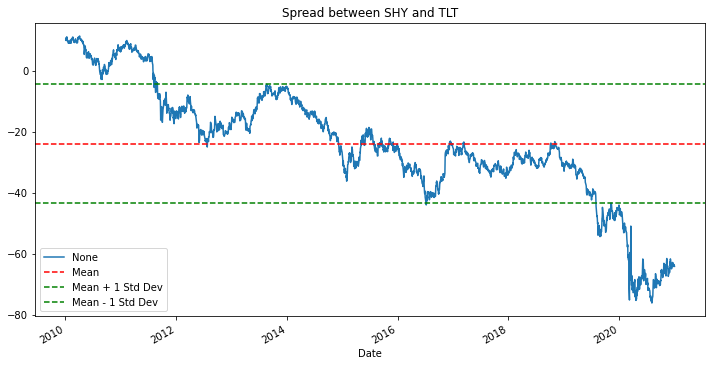

In [25]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller



# Select one of the mean-reverting pairs (for example, the first pair)
selected_pair = mean_reverting_pairs[0][0] if mean_reverting_pairs else None
selected_pair=('SHY', 'TLT')
if not selected_pair:
    raise ValueError("No mean-reverting pair found.")

# Calculate the spread
spread = data[selected_pair[0]] - data[selected_pair[1]]
spread_mean = spread.mean()
spread_std = spread.std()

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(spread)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Values ({key}): {value}')

# Plot the spread
plt.figure(figsize=(12, 6))
spread.plot(title=f'Spread between {selected_pair[0]} and {selected_pair[1]}')
plt.axhline(spread_mean, color='red', linestyle='--', label='Mean')
plt.axhline(spread_mean + spread_std, color='green', linestyle='--', label='Mean + 1 Std Dev')
plt.axhline(spread_mean - spread_std, color='green', linestyle='--', label='Mean - 1 Std Dev')
plt.legend()
plt.show()


In [26]:
# Define thresholds for entering and exiting trades
entry_threshold = 1.5  # Enter trade if 1.5 standard deviations away from mean
exit_threshold = 0.5   # Exit trade if 0.5 standard deviations away from mean

# Create columns for trade signals
data['Long Entry'] = (spread < spread_mean - entry_threshold * spread_std)
data['Long Exit'] = (spread >= spread_mean - exit_threshold * spread_std)
data['Short Entry'] = (spread > spread_mean + entry_threshold * spread_std)
data['Short Exit'] = (spread <= spread_mean + exit_threshold * spread_std)

# Initialize a position column
data['Position'] = 0

# Strategy Logic
for i in range(1, len(data)):
    if data['Long Entry'][i] and data['Position'][i-1] == 0:
        data['Position'][i] = 1  # Go long
    elif data['Short Entry'][i] and data['Position'][i-1] == 0:
        data['Position'][i] = -1  # Go short
    elif data['Long Exit'][i] and data['Position'][i-1] == 1:
        data['Position'][i] = 0  # Exit long
    elif data['Short Exit'][i] and data['Position'][i-1] == -1:
        data['Position'][i] = 0  # Exit short
    else:
        data['Position'][i] = data['Position'][i-1]  # Hold position

# Display a snippet of the DataFrame with signals
print(data[['Long Entry', 'Short Entry', 'Long Exit', 'Short Exit', 'Position']].tail(10))


C:\Users\MSI\AppData\Local\Temp\ipykernel_29088\2438463915.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][i] = -1  # Go short
C:\Users\MSI\AppData\Local\Temp\ipykernel_29088\2438463915.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][i] = data['Position'][i-1]  # Hold position
C:\Users\MSI\AppData\Local\Temp\ipykernel_29088\2438463915.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[

            Long Entry  Short Entry  Long Exit  Short Exit  Position
Date                                                                
2020-12-17        True        False      False        True         1
2020-12-18        True        False      False        True         1
2020-12-21        True        False      False        True         1
2020-12-22        True        False      False        True         1
2020-12-23        True        False      False        True         1
2020-12-24        True        False      False        True         1
2020-12-28        True        False      False        True         1
2020-12-29        True        False      False        True         1
2020-12-30        True        False      False        True         1
2020-12-31        True        False      False        True         1


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


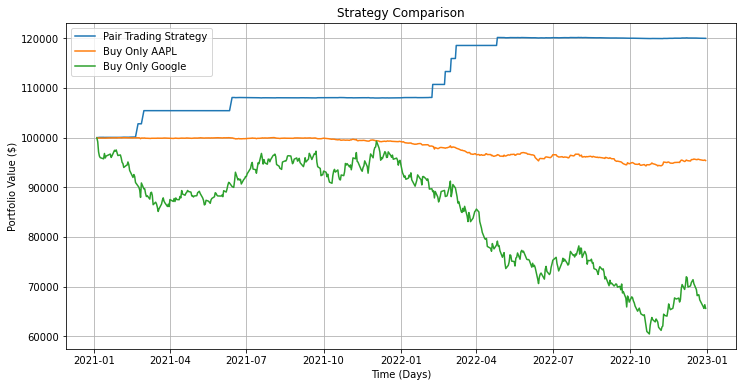

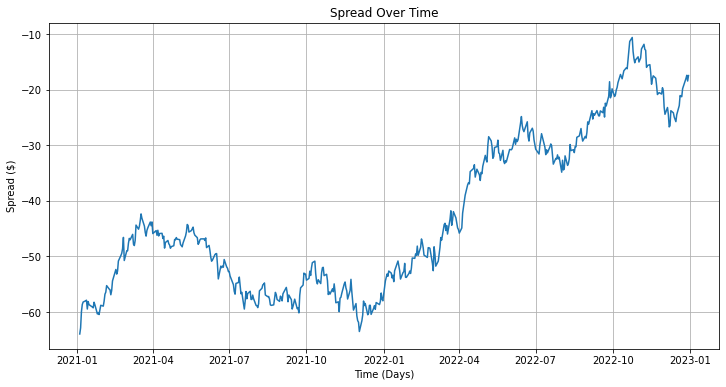

Total Return: 19.98%
Portfolio Volatility: 4.65%
Sharpe Ratio: 1.99


In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download Data
data1 = yf.download('SHY', start='2021-01-01', end='2023-01-01')['Adj Close']
data2 = yf.download('TLT', start='2021-01-01', end='2023-01-01')['Adj Close']

# Parameters
transaction_fee = 0.1  # Transaction fee per trade
shares = 10  # Number of shares to trade

# Calculate the spread
spread = data1 - data2
spread_mean = spread.mean()
spread_std = spread.std()

# Define trading signals
entry_threshold = 0.5
exit_threshold = 0.5
data = pd.DataFrame({'spread': spread})
data['Long Entry'] = data['spread'] < (spread_mean - entry_threshold * spread_std)
data['Short Entry'] = data['spread'] > (spread_mean + entry_threshold * spread_std)
data['Long Exit'] = data['spread'] >= (spread_mean - exit_threshold * spread_std)
data['Short Exit'] = data['spread'] <= (spread_mean + exit_threshold * spread_std)

# Simulate Pair Trading Strategy
inv = 100000
cash = 100000
position = 0
portfolio_value = [cash]
for i in range(1, len(data)):
    if data['Long Entry'].iloc[i] and position == 0:
        cash -= (shares * data1.iloc[i] + transaction_fee)
        cash += (shares * data2.iloc[i] - transaction_fee)
        position = 1
    elif data['Short Entry'].iloc[i] and position == 0:
        cash += (shares * data1.iloc[i] - transaction_fee)
        cash -= (shares * data2.iloc[i] + transaction_fee)
        position = -1
    elif (data['Long Exit'].iloc[i] and position == 1) or (data['Short Exit'].iloc[i] and position == -1):
        cash += (shares * data1.iloc[i] - transaction_fee)
        cash += (shares * data2.iloc[i] - transaction_fee)
        position = 0
    portfolio_value.append(cash + position * (shares * (data1.iloc[i] - data2.iloc[i])))

# Calculate Total Return and Other Metrics
total_return = (portfolio_value[-1] / portfolio_value[0]) - 1
returns = pd.Series(portfolio_value).pct_change().fillna(0)
sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
portfolio_volatility = returns.std() * np.sqrt(252)

# Simulate Buy Only Strategies
buy_only_aapl = data1 * (inv // data1.iloc[0])
buy_only_msft = data2 * (inv // data2.iloc[0])

# Plotting Portfolio Value and Buy Only Strategies
plt.figure(figsize=(12, 6))
plt.plot(buy_only_aapl.index,portfolio_value, label='Pair Trading Strategy')
plt.plot(buy_only_aapl.index,buy_only_aapl, label='Buy Only AAPL')
plt.plot(buy_only_aapl.index,buy_only_msft, label='Buy Only Google')
plt.title('Strategy Comparison')
plt.xlabel('Time (Days)')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Spread
plt.figure(figsize=(12, 6))
plt.plot(data['spread'])
plt.title('Spread Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Spread ($)')
plt.grid(True)
plt.show()

# Print Performance Metrics
print(f"Total Return: {total_return:.2%}")
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
